# Visualization of $K_1$ Discontinuities

In [27]:
import os
import re
import torch
import pickle
import numpy as np
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [5]:
DATA_DIR = Path("../data/k0/sentiment-analysis")

In [6]:
labels = pickle.load(open(DATA_DIR / "labels.pkl", "rb"))
# convert all of the labels to ints 
labels = [int(v) for v in labels]

## Preprocessing
- We load the ground truth labels, logits from the neural network, and activations from each layer of the neural network. 
- We load and average the last hidden states of the embedding neural network.
- Apply softmax to the logits and only get the probabilities corresponding to the correct label.

In [8]:
# load the activation data and the predictions
TARGET_MODEL_NAME = "bert-base-uncased-imdb"
activations = pickle.load(open(DATA_DIR / f"{TARGET_MODEL_NAME}-k0.pkl", "rb"))

In [9]:
logits = torch.cat([v[0] for v in activations])  # load all of the logits

# apply softmax to the logits to get raw probabilities
def softmax(x):
    return torch.exp(x) / torch.sum(torch.exp(x), axis=1).reshape(-1,1)

# we only care about the probabilites that correspond to the correct label
predicted_probs = softmax(logits)[torch.arange(len(logits)),labels]

In [10]:
REFERENCE_MODELS = [
    "bert-base-uncased-imdb",
    "bert-large-uncased-imdb", 
    "roberta-base-imdb",
    "roberta-large-imdb"
]

In [33]:
# get all of the last hidden layers of the activations for each model
acts = []
for model in REFERENCE_MODELS:
    activations = pickle.load(open(DATA_DIR / f"{model}-k0.pkl", "rb"))
    model_acts = []
    for v in activations:
        model_acts.append(v[1][-1])
    acts.append(torch.cat(model_acts))

## Probability with PCA-ed Activations
- We plot the probability that the model predicts correctly for a given data point with the PCA-ed (2 dimension) of that data point with respect to each of the reference model embeddings.
- The purpose of these plots is to give an idea of whether or not K1 discontinuities will be consistent across many different learned representations of the embedding space. 

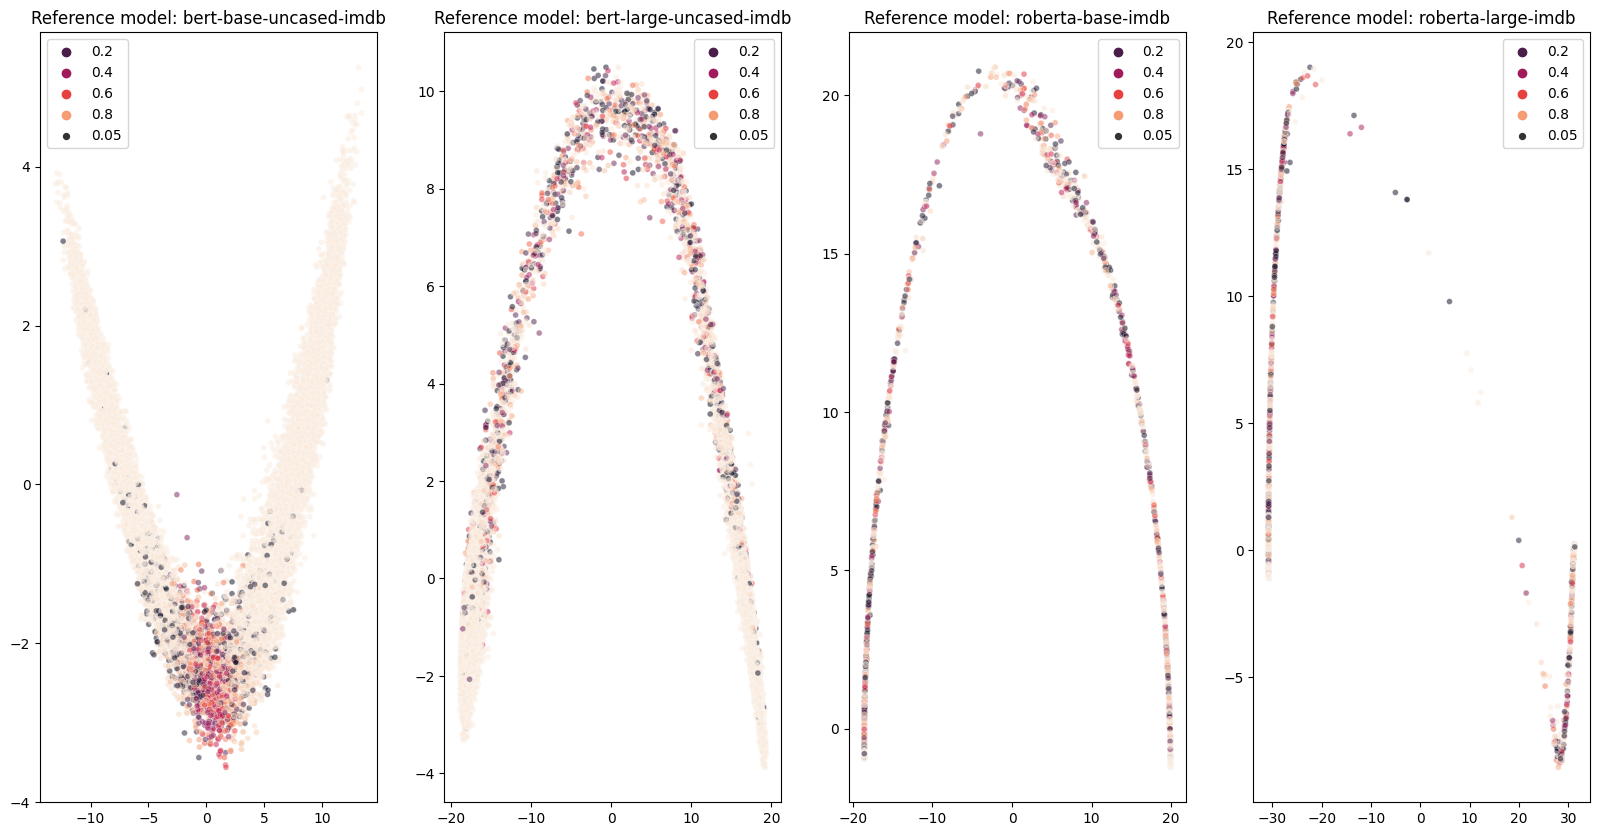

In [38]:
fig, axs = plt.subplots(1,len(REFERENCE_MODELS), figsize=(20,10))
for i, act in enumerate(acts):
    pca = PCA(n_components=2)
    two_dim_act = pca.fit_transform(act)
    ax = axs.flat[i]
    ax.set_title(f"Reference model: {REFERENCE_MODELS[i]}")
    sns.scatterplot(
        x=two_dim_act[:,0],
        y=two_dim_act[:,1],
        hue=predicted_probs,
        size=0.05,
        palette="rocket",
        alpha=0.5,
        ax=axs.flat[i]
    )

Let's also plot the actual labels vs. the embedded dimensions. This helps us identify a potential decision boundary.

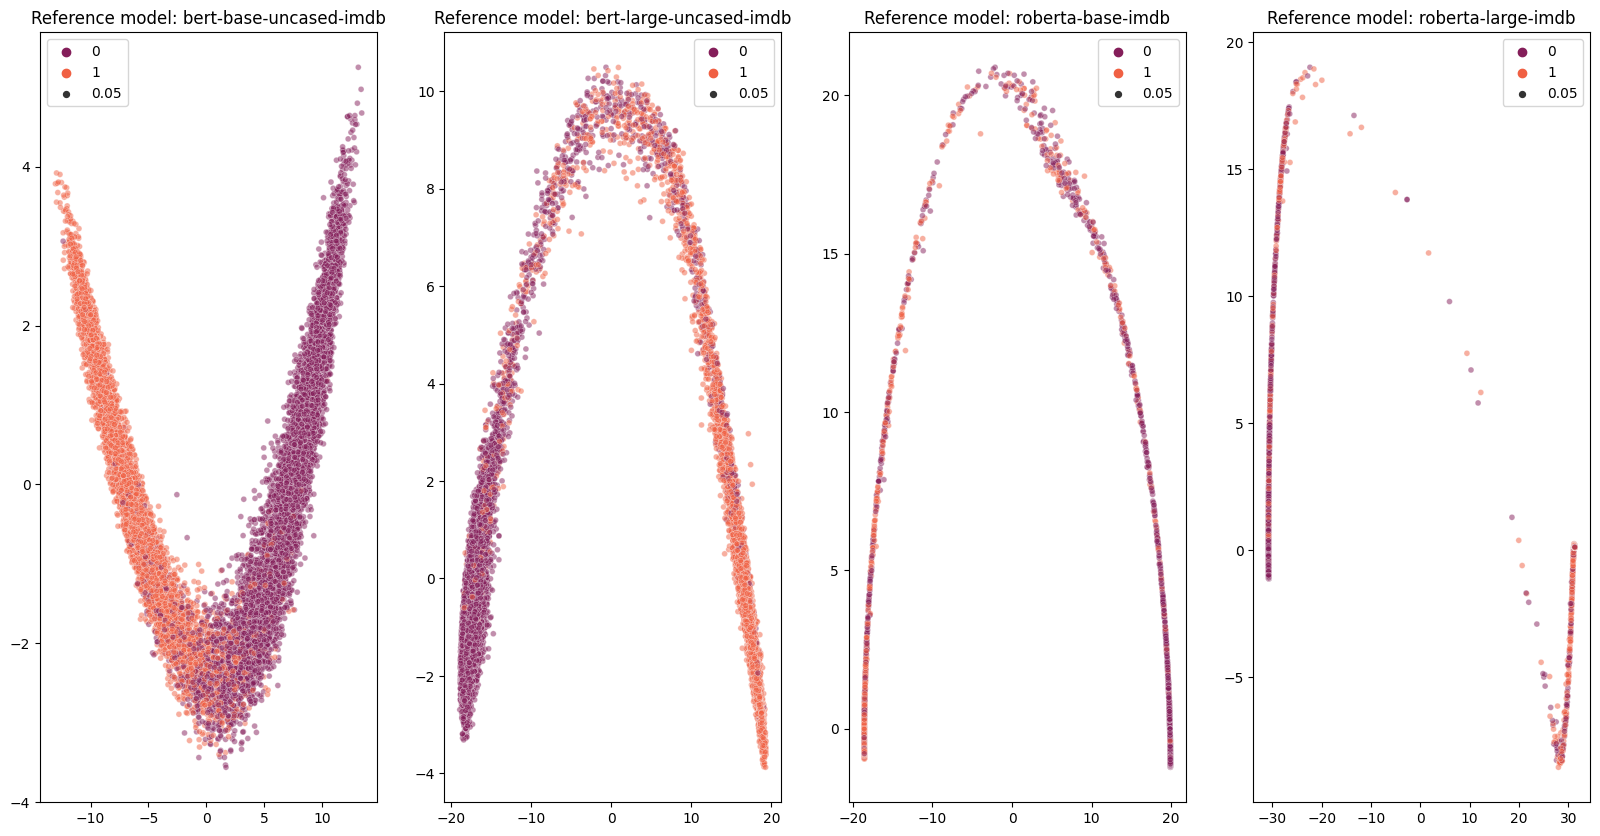

In [39]:
fig, axs = plt.subplots(1,len(REFERENCE_MODELS), figsize=(20,10))
for i, act in enumerate(acts):
    pca = PCA(n_components=2)
    two_dim_act = pca.fit_transform(act)
    ax = axs.flat[i]
    ax.set_title(f"Reference model: {REFERENCE_MODELS[i]}")
    sns.scatterplot(
        x=two_dim_act[:,0],
        y=two_dim_act[:,1],
        hue=labels,
        size=0.05,
        palette="rocket",
        alpha=0.5,
        ax=axs.flat[i]
    )